# Atividade Prática 4

## Compressão usando DCT

### Entrega: até 08/10/2021 às 23:59 no e-disciplinas

#### Nome: Ciro B Rosa N° USP: 2320769  ( ) Grad (X) Pós

###  Revisão

A DCT foi definida na seção 3.4 a partir de uma adaptação da transformada de Fourier: um vetor $x=\overrightarrow{x}\in\mathbb{R}^N$ era duplicado de forma espelhada $\tilde{x}=(\overrightarrow{x},\overleftarrow{x})$ e as redundâncias encontradas na transformada de Fourier $\tilde{X}\in\mathbb{C}^{2N}$ eram exploradas para recodificá-la na forma de um vetor $C=\mbox{DCT}(x)\in\mathbb{R}^N$:
\begin{align*}
	C_0 &= \sqrt{\frac{1}{N}}\sum\limits_{m=0}^{N-1} x_m \\
	C_k &= \sqrt{\frac{2}{N}}\sum\limits_{m=0}^{N-1} x_m\cos\left(\frac{\pi k\left(m+\frac{1}{2}\right)}{N}\right), k = 1, 2, \dots, N-1,\\
\end{align*}

cuja transformada inversa ($x=IDCT(C)$) é

\begin{equation*}
	x_m = \sqrt{\frac{1}{N}}C_0 + \sqrt{\frac{2}{N}}\sum\limits_{k=1}^{N-1}C_k\cos\left(\frac{\pi\left(m + \frac{1}{2}\right)k}{N}\right),\ m=0,1,\ldots,N-1.
\end{equation*}

Vimos também o esquema simples de compressão por limiarização da seção 3.3, que pode ser aplicado tanto à FFT quanto à DCT: dado $x\in\mathbb{R}^N$ e um parâmetro de limiarização $c\in[0,1]$, faça:

> Compressão/Descompressão(x):
>
>> $\mbox{compute}\ C=DCT(x)$
>>
>> $\mbox{calcule}\ M=\max\{|C_k|,\ k=0,\ldots,N-1\}$
>>
>> $\mbox{defina}\ \tilde{C}\in\mathbb{R}^N\ \mbox{como}$    
$$\tilde{C}_k = \left\{\begin{array}{ll}
    C_k&\mbox{se}\ |C_k|\ge cM,\\
    0&\mbox{c.c.}\end{array}\right.$$
>>
>> $\mbox{calcule o sinal reconstruído como}\ \tilde{x} = IDCT(\tilde{C})$
>>
>> $\mbox{calcule a taxa de compressão como}\ P(c) = \frac{\#\{k\mid|C_k|\ge cM\}}{N}$
>>
>> $\mbox{calcule a distorção como}\ D(c) = \frac{\|x-\tilde{x}\|^2}{\|x\|^2}$
>>
>> 

O código a seguir usa a DCT (rápida) da SciPy e a compressão por limiarização da DCT em um exemplo de sinal simples com descontinuidade, usando $c=0.1$, e também mostra como a distorção se relaciona com a taxa de compressão nesse sinal:

In [1]:
# importa dependências
import math as m
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct, idct

# realiza compressão/descompressão de x com parâmetro de limiarização c e devolve x~, Dc e Pc
def CompDescomp(x,c):
    # calcula DCT e faz compressão por limiarização
    C=dct(x, norm='ortho')
    cM = c*np.max(abs(C)) # limiar de compressão
    CC = C*(abs(C)>=cM) # DCT comprimida
    xtil = idct(CC, norm='ortho') # sinal reconstruído
    Pc = sum(abs(C)>=cM)/x.size # taxa de compressão (proporção de coeficientes mantidos)
    if np.linalg.norm(x)**2>0:
        Dc = np.linalg.norm(x-xtil)**2/np.linalg.norm(x)**2 # distorção relativa
    else:
        Dc = np.linalg.norm(x-xtil)**2 # calcula distorção absoluta se sinal é nulo
    return xtil,Pc,Dc

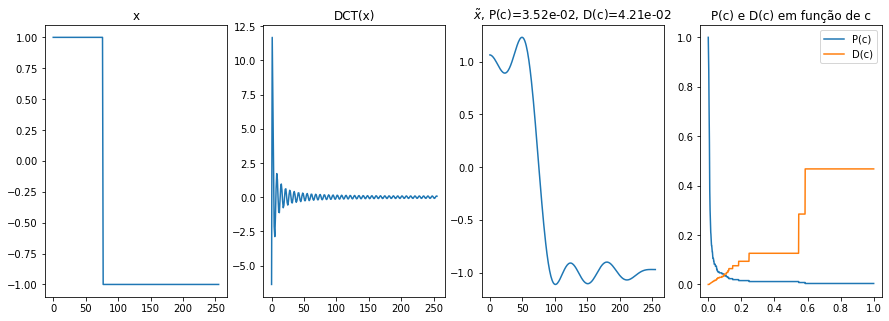

In [2]:
# gera sinal descontínuo com 30% de +1 e o restante -1, no intervalo [0,256)
N=256;M=0.3;x = -1+2*(np.array(range(N))<M*N);

# realiza compressão/descompressão com c=0.1
xtil,Pc,Dc = CompDescomp(x,0.1)

# gera gráficos de x, DCT(x) e x_til
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].set_title(r'x');ax[0].plot(x)
ax[1].set_title(r'DCT(x)');ax[1].plot(dct(x, norm='ortho'))
ax[2].set_title(r'$\tilde{{x}}$, P(c)={0:.2e}, D(c)={1:.2e}'.format(Pc,Dc));ax[2].plot(xtil)

# gera gráficos de P(c) e D(c) usando a função CompDescomp
eps = 1e-3
c = np.arange(0,1+eps,eps)
Pc = np.zeros(len(c))
Dc = np.zeros(len(c))
for i in range(len(c)):
    dummy,Pc[i],Dc[i] = CompDescomp(x,c[i])
ax[3].set_title(r'P(c) e D(c) em função de c');ax[3].plot(c,Pc,label='P(c)');ax[3].plot(c,Dc,label='D(c)');
plt.legend();plt.show();

---

**Exercício 1:** 

**(a)** Escreva uma função <tt>c_ótimo(x,d)</tt> que encontra um limiar ótimo $c^*$ em função da distorção máxima $d$ admissível na compressão do sinal x. Para isso, seu código deve buscar o maior valor de $c$ (aquele que corta mais coeficientes da DCT) que satisfaz $D(c)\le d$. Sua solução $c^*$ deve possuir acurácia de $\varepsilon=0.001$ (estar a no máximo $\varepsilon$ de distância do ótimo verdadeiro).

**Dica:** você pode fazer isso tanto por busca simples (percorrendo valores de $c$ de $\varepsilon$ em $\varepsilon$) quanto por busca binária (subdividindo o intervalo $[c_0,c_1]$ ao meio mantendo a propriedade $D(c_0)\le d$ e $D(c_1)>d$). Certifique-se de que o $c^*$ devolvido de fato satisfaz $D(c^*)\le d$: no caso da busca simples ascendente talvez você tenha que devolver o *penúltimo* valor de $c$ testado, e no caso da busca binária o melhor é devolver a extremidade *inferior* (e não o ponto médio) do último intervalo testado.

**Dica 2:** Se quiser utilizar o método da busca binária, pode valer a pena olhar o [método da bisseção](https://www.ufrgs.br/reamat/CalculoNumerico/livro-py/sdeduv-metodo_da_bissecao.html).

**(b)** Use sua função para plotar o limiar ótimo $c^*$ como função de $d$, para $d\in[0,1]$.

**Dica:** esse gráfico deve ser bem parecido com o gráfico de $D(c)$ acima, porém transposto.

In [3]:
# Resposta do exercício 1a
def c_otimo(x, d):
    eps = 0.001
    c = np.arange(0, 1 + eps, eps)
    
    for i in range(len(c)):
        Dc = CompDescomp(x, c[i])[2]
        cStar = c[i]
        if Dc > d:
            cStar = c[i-1] 
            if i == 0:
                cStar = 0                
            break
    
    return (cStar)

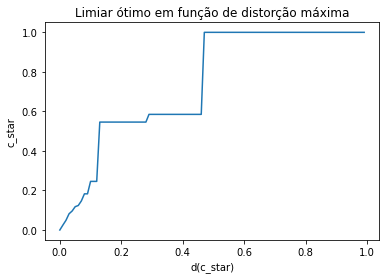

In [4]:
# Resposta do exercício 1b
d = np.arange(0, 1, 0.01)
cStar = np.zeros(len(d))
for i in range(len(d)):
    cStar[i] = c_otimo(x, d[i])

plt.title("Limiar ótimo em função de distorção máxima")
plt.xlabel('d(c_star)'); plt.ylabel('c_star')
plt.plot(d, cStar)

### Melhorando o resultado da compressão

O exemplo do pulso quadrado é interessante por duas razões: ele traz a descontinuidade no interior do intervalo, o que representa um problema tanto para a DFT quanto para a DCT, mas ele também ilustra a melhor eficiência da DCT por eliminar a "descontinuidade da borda" (associada à repetição periódica do padrão implícita na DFT).

Uma forma de reduzir esse problema é aplicar uma estratégia segmentada para a compressão: se o sinal for segmentado em intervalos de tamanho $B$, apenas um desses intervalos conterá a descontinuidade em seu interior, e todos os demais intervalos devem ser muito mais fáceis de comprimir (pois são constantes nesse exemplo). Em outras palavras, $x=(x_0,\ldots,x_{N-1})$ será dividido em segmentos
$$x^{(m)}=\left\{\begin{array}{ll}
(x_{m*B},\ldots,x_{(m+1)*B-1})& m=0,1,\ldots,\lfloor N/B\rfloor-1,\\
(x_{m*B},\ldots,x_{N-1})& m=\lfloor N/B\rfloor\quad\mbox{(apenas se $B$ não divide $N$)},\\
\end{array}\right.$$
e cada segmento $x^{(m)}$ é comprimido de forma independente, usando os melhores limiares possíveis.

**Exercício 2:** 

**(a)** Escreva uma função <tt>CompDescompSegm(x,B)</tt> que recorte o sinal $x$ em segmentos de tamanho $B$ e aplique a estratégia de compressão em cada segmento, escolhendo o limiar ótimo em cada um deles de forma a garantir uma distorção relativa menor que $\delta=10^{-8}$ em cada segmento. Sua função deve devolver o sinal reconstruído $\tilde{x}$, a taxa de compressão $P$ e a distorção relativa $D$. Você pode considerar que $B$ divide $N$, de tal forma que o número de segmentos será exatamente $\frac{N}{B}$.

**Dica:** A taxa de compressão pode ser computada como a média dos valores $P_1(c_1),P_2(c_2),\ldots,P_M(c_M)$, e a distorção relativa deve ser calculada pela fórmula usual $D=\frac{\|x-\tilde{x}\|^2}{\|x\|^2}$ usando os vetores completos.

**(b)** Use sua função para construir dois gráficos separados, de $P$ e $D$ em função de $B=1,2,4,8,\ldots,N$. Comente na célula seguinte ao código sua interpretação para os perfis observados. Em particular, diga se existe um valor de $B$ que otimize a taxa de compressão $P$.

**Dica:** Use um eixo x logarítmico na base 2 para facilitar a visualização, com o comando <tt>ax[i].set_xscale('log',base=2)</tt>

In [5]:
# Resposta do exercício 2a
def CompDescompSegm(x, B):

    qtSeg = int(len(x) / B)
    xSegments = []

    delta = 1e-8
    cStar        = np.zeros(qtSeg)
    xTilSegments = []
    PcSegments   = np.zeros(qtSeg)
    DcSegments   = np.zeros(qtSeg)

    for i in range(qtSeg):

        # recortar x em segmentos
        a = i * B
        b = (i+1) * B
        s = x[a : b]
        xSegments.append(s)
        
        # comprimir cada segmento e escolher o respectivo limiar ótimo
        cStar[i] = c_otimo(xSegments[i], delta)
        xTilSeg, PcSegments[i], DcSegments[i] = CompDescomp(xSegments[i], cStar[i])
        xTilSegments.append(xTilSeg)
    
    # Calcula sinal reconstruído
    xTil = np.ravel(xTilSegments)
    
    # Calcula a taxa de compressão média
    Pc = np.mean(PcSegments)
    
    # Calcula a distorção relativa
    Dc = ( np.linalg.norm(x - xTil) ** 2 ) / ( np.linalg.norm(x) ** 2 )

    return (xTil, Pc, Dc)

# Verifica a execução para B = 4
xTil, Pc, Dc = CompDescompSegm(x, 4)

print(xTil)
print(Pc, Dc)


[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

Valores de B: [  1   2   4   8  16  32  64 128 256]


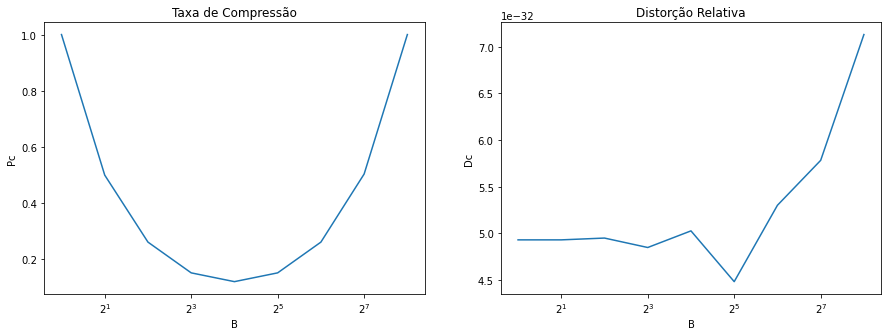

In [20]:
# Resposta do exercício 2b
B  = np.power(2, np.arange(9))
print("Valores de B:", B)
Pc = np.zeros(len(B))
Dc = np.zeros(len(B))
for i in range(len(B)):
    dummy, Pc[i], Dc[i] = CompDescompSegm(x, B[i])
    #print(i, B[i], Pc[i], Dc[i])

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].set_title("Taxa de Compressão")
ax[0].set_xlabel('B')
ax[0].set_ylabel('Pc')
ax[0].semilogx(B, Pc, base=2)

ax[1].set_title("Distorção Relativa")
ax[1].set_xlabel('B')
ax[1].set_ylabel('Dc')
ax[1].semilogx(B, Dc, base = 2)

plt.show()

**Comentários da questão 2b**



Sobre o gráfico da taxa de compressão, observa-se que para segmentos B muito pequenos ou muito grandes, a compressão Pc é relativamente ineficaz